# Dataset 3 processing and descriptive analysis

This notebooks loads and processes the Dataset 3 and analyzes its mapping with PathMe, stratificating it by omic and by database.

Finally, it exports to the format ready to be used by DiffuPy/DiffuPath

In [1]:
import os 
import pybel
from pybel_tools.summary import plot_summary, count_top_centrality
import matplotlib.pyplot as plt

import json
import networkx as nx

from diffupath.constants import DEFAULT_DIFFUPATH_DIR, ROOT_RESULTS_DIR
from diffupath.pathme_processing import get_labels_by_db_and_omic_from_pathme, get_labels_by_db_and_omic_from_graph
from diffupath.utils import print_dict_dimensions, get_labels_set_from_dict, reduce_dict_dimension, get_count_and_labels_from_two_dim_dict, from_pickle, to_pickle, get_three_venn_intersections, random_disjoint_intersection_three_subsets
from diffupath.views import show_heatmap

from diffupy.process_input import process_input_data
from diffupy.utils import lists_combinations, parse_xls_to_df, to_json
from diffupy.constants import *

## 1. Load and process dataset

### 1.1. Dataset excel file parsing

In [3]:
VALIDATION_PATH = os.path.join(ROOT_RESULTS_DIR, 'data', 'validation_datasets')
VALSET_3_PATH = os.path.join(VALIDATION_PATH, 'set3.xlsx')

##### Parsing parameters

In [4]:
relevant_sheets = ['metabolites', 
                 'genes', 
                 'mirnas']

relevant_cols = ['miRNA', 
                 'Gene name', 
                 'Name',
                 'p-value',
                 'P-value'
                ]

cols_titles_mapping = {'miRNA': NODE, 
                       'Gene name': NODE, 
                       'Name': NODE, 
                       'p-value': P_VALUE, 
                       'P-value':P_VALUE, 
                      }

##### Dataset excel parsing

In [5]:
parsed_xls = parse_xls_to_df(VALSET_3_PATH,
                             min_row = 2,
                             relevant_sheets = relevant_sheets,
                             relevant_cols = relevant_cols
                            )

### 1.2. Process input data

In [6]:
processed_input_data = process_input_data(parsed_xls,
                                          cols_titles_mapping = cols_titles_mapping
                                          )
merged_processed_input_data = {label:score for subtype, entities in processed_input_data.items() for label, score in entities.items()}


## 2. Load background network graph

In [8]:
GRAPH_PATH = os.path.join(DEFAULT_DIFFUPATH_DIR, 'pickles', 'universe', 'pathme_universe_non_flatten_collapsed_names_no_isolates_16_03_2020.pickle')


PathMe Universe v1.0.0
Number of Nodes: 42272
Number of Edges: 105871
Number of Citations: 7695
Number of Authors: 0
Network Density: 5.92E-05
Number of Components: 435
Number of Warnings: 0


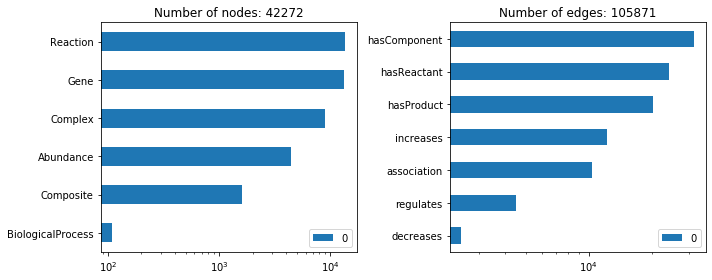

In [9]:
pathme_universe_graph_no_flatten = pybel.from_pickle(GRAPH_PATH)
pathme_universe_graph_no_flatten.summarize()

nx.number_of_isolates(pathme_universe_graph_no_flatten)
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

In [10]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(pathme_universe_graph_no_flatten)

print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')


Total number of  wikipathways: gene_nodes(2555), mirna_nodes(91), metabolite_nodes(637), bp_nodes(138),  
Total number of  kegg: gene_nodes(6048), mirna_nodes(122), metabolite_nodes(1770), bp_nodes(107),  
Total number of  reactome: gene_nodes(8617), mirna_nodes(13), metabolite_nodes(2682), bp_nodes(3),  
Total: 18001 


In [11]:
bg_labels_from_pathmeuniverse_by_db = reduce_dict_dimension(bg_labels_from_pathmeuniverse_by_db_and_omic)
print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db, 'Entities in PathMeUniverse :')

Total number of  wikipathways: 3421  
Total number of  kegg: 8047  
Total number of  reactome: 11315  
Total: 18001 


In [12]:
bg_labels_from_pathmeuniverse_by_omic = reduce_dict_dimension(bg_labels_from_pathmeuniverse_by_omic_and_db)
print_dict_dimensions(bg_labels_from_pathmeuniverse_by_omic, 'Entities in PathMeUniverse :')

Total number of  gene_nodes: 18001  
Total number of  mirna_nodes: 171  
Total number of  metabolite_nodes: 4306  
Total number of  bp_nodes: 248  
Total: 18001 


## 3. Mapping

In [13]:
from diffupy.process_input import map_labels_input
from diffupy.process_input import mapping_statistics

##### Quantitative

In [14]:
mapping_by_database_and_entity = map_labels_input(input_labels=merged_processed_input_data,
                                                  background_labels=bg_labels_from_pathmeuniverse_by_db_and_omic,
                                                  show_descriptive_stat= True,
                                                  check_substrings = ['mirna_nodes']
                                                  )

mapping_by_database_and_entity_statistics = mapping_statistics(merged_processed_input_data, 
                                                               mapping_by_database_and_entity)

Mapping descriptive statistics

wikipathways:
gene_nodes  ((28, 0.4375))
mirna_nodes  ((4, 1.0))
metabolite_nodes  ((22, 0.6111111111111112))
bp_nodes  ((7, 1.0))
total  ((51, 0.5862068965517241))

kegg:
gene_nodes  ((35, 0.546875))
mirna_nodes  ((4, 1.0))
metabolite_nodes  ((13, 0.3611111111111111))
bp_nodes  ((6, 0.8571428571428571))
total  ((43, 0.4942528735632184))

reactome:
gene_nodes  ((32, 0.5))
mirna_nodes  ((1, 0.25))
metabolite_nodes  ((17, 0.4722222222222222))
bp_nodes  ((1, 0.14285714285714285))
total  ((43, 0.4942528735632184))

total:
gene_nodes  ((64, 0.735632183908046))
mirna_nodes  ((4, 0.04597701149425287))
metabolite_nodes  ((36, 0.41379310344827586))
bp_nodes  ((7, 0.08045977011494253))
total  ((88, 1.0114942528735633))





##### Descriptive data view

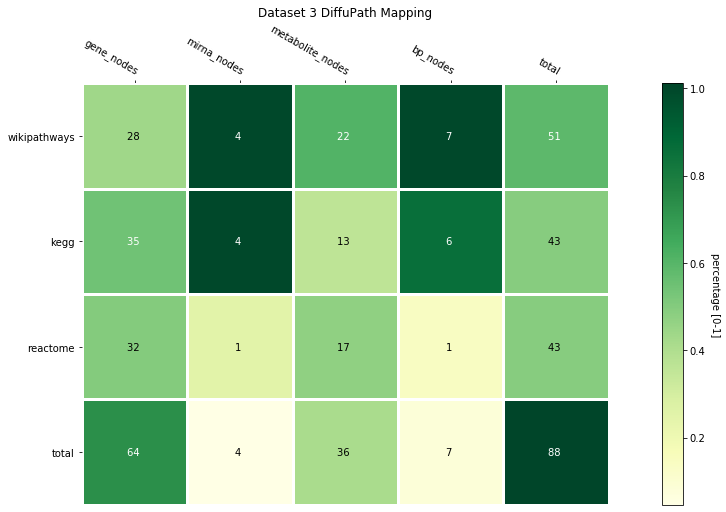

In [16]:
count, percentage, db_labels, entity_labels  = get_count_and_labels_from_two_dim_dict(mapping_by_database_and_entity_statistics)

show_heatmap(count, percentage, db_labels, entity_labels, 'Dataset 3 DiffuPath Mapping')


##### Save mapping by_db_and_entity to exportable .json file

In [17]:
MAPPING_OUTPUT_PATH = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_3_mapping.json')
to_json(mapping_by_database_and_entity, MAPPING_OUTPUT_PATH)